1. Definicja problemu

Celem projektu była analiza dziennych przychodów sklepu internetowego oraz ocena możliwości ich krótkoterminowego prognozowania na podstawie danych historycznych. Prognozowanie sprzedaży stanowi istotny element analizy danych biznesowych, ponieważ wspiera podejmowanie decyzji związanych z planowaniem zapasów, logistyką, zarządzaniem personelem oraz strategią marketingową.

W projekcie postawiono następujące pytanie badawcze:

Czy dzienne przychody wykazują trend i sezonowość oraz który z klasycznych modeli szeregów czasowych – ETS czy SARIMA – lepiej radzi sobie z krótkoterminowym prognozowaniem danych sprzedażowych?

Hipotezą roboczą było, że model ETS (Exponential Smoothing) osiągnie lepszą jakość krótkoterminowych prognoz dziennych przychodów niż model SARIMA, ze względu na silną sezonowość tygodniową danych oraz relatywnie krótki horyzont prognozy.

2. Pozyskanie danych

Dane wykorzystane w projekcie pochodzą z otwartego zbioru Online Retail Dataset, udostępnionego na platformie Kaggle. Zbiór zawiera rzeczywiste transakcje brytyjskiego sklepu internetowego z lat 2010–2011 i obejmuje szczegółowe informacje o sprzedaży, takie jak numer faktury, data transakcji, ilość, cena jednostkowa, identyfikator klienta oraz kraj pochodzenia.

Źródło danych:
Kaggle – Online Retail Dataset
https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset

Dane mają charakter transakcyjny, dlatego przed właściwą analizą wymagały agregacji do postaci dziennego szeregu czasowego.

3. Eksploracja i przygotowanie danych

Na etapie eksploracji danych:

wczytano dane do środowiska Python (Jupyter Notebook),

sprawdzono kompletność kolumn oraz zakresy wartości,

zidentyfikowano anulacje transakcji (numery faktur rozpoczynające się od litery „C”),

usunięto zwroty (ujemne ilości) oraz ceny zerowe i ujemne.

Następnie obliczono dzienne przychody (revenue) jako iloczyn ilości i ceny jednostkowej, a dane zagregowano do kanonicznego dziennego szeregu czasowego. Dni bez sprzedaży zostały jawnie oznaczone wartością 0, co umożliwia poprawne modelowanie sezonowości.

Eksploracja wizualna (wykresy szeregu czasowego, średnie kroczące, boxploty według dnia tygodnia):

potwierdziła obecność trendu wzrostowego,

ujawniła bardzo silną sezonowość tygodniową, z wyraźnie niższą sprzedażą w weekendy,

wykazała niestacjonarność szeregu w poziomach.

4. Modelowanie i prognozowanie

W projekcie zastosowano dwa klasyczne modele szeregów czasowych:

Exponential Smoothing (ETS / Holt–Winters) – model bazowy uwzględniający trend addytywny oraz sezonowość tygodniową,

SARIMA – model autoregresyjny z różnicowaniem oraz sezonowością tygodniową.

Model ETS został skonfigurowany z trendem addytywnym i sezonowością addytywną o okresie 7 dni. Model SARIMA został dobrany na podstawie analizy stacjonarności (test ADF) oraz przeszukiwania siatki parametrów z wykorzystaniem kryterium AIC.

Modele trenowano i oceniano w dwóch schematach:

klasycznym podziale train/test (ostatnie 30 dni jako zbiór testowy),

rozszerzonej walidacji typu walk-forward (expanding window), symulującej wielokrotne prognozowanie przyszłych okresów.

5. Walidacja i ocena modeli

Do oceny jakości prognoz wykorzystano następujące metryki:

MAE (Mean Absolute Error),

RMSE (Root Mean Squared Error),

Bias – średni błąd wskazujący na systematyczne przeszacowanie lub niedoszacowanie prognoz.

In [1]:
import pandas as pd

df = pd.read_csv("online_retail.csv") # zapisanie pliku jako df

df.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [2]:
df.info() # jaki typ danej kolumny, ile jest not-null
df.shape #kształt ramki danych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(541909, 8)

In [3]:
df.isna().sum() #pokazuje ile w każdej kolumnie jest braków danych
# po analizie ręcznej danych i znalezieniu brakujących jest to albo duży błąd systemu albo przekręt i jkieś nielegalne
# rzeczy

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df_sorted = df.sort_values("InvoiceDate").reset_index(drop=True) #resetowanie indexów
missing_idx = df_sorted[df_sorted["CustomerID"].isna()].sample(n=10, random_state=42).index #isns - czy jest brak danych
#smaple - podobne do head, ale zwraca losowe 10 rekordów, random_state - pozwala komputerowi randomizować 

k = 3
context_idx = []
for i in missing_idx:
    context_idx.extend(range(i-k, i+k+1)) #dodaje określoneelementy listy do końca bierzącej listy
    #dodaje najbliższe otoczenie wyszukanego pustego CustomerId

context = df_sorted.loc[sorted(set(context_idx))]
context
#losowa próbka CustomerID = NaN i jej otoczenie

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
20911,538071,90013B,BLACK VINTAGE EARRINGS,1,2010-12-09 14:09:00,4.24,NaN,United Kingdom
20912,538071,90013C,GREEN VINTAGE EARRINGS,1,2010-12-09 14:09:00,4.24,NaN,United Kingdom
20913,538071,90030B,RED KUKUI COCONUT SEED NECKLACE,1,2010-12-09 14:09:00,5.94,NaN,United Kingdom
20914,538071,90030C,BROWN KUKUI COCONUT SEED NECKLACE,1,2010-12-09 14:09:00,5.94,NaN,United Kingdom
20915,538071,90039B,FIRE POLISHED GLASS BRACELET MONTAN,1,2010-12-09 14:09:00,3.81,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
497131,578347,22186,RED STAR CARD HOLDER,2,2011-11-24 09:26:00,5.79,NaN,United Kingdom
497132,578347,22340,NOEL GARLAND PAINTED ZINC,7,2011-11-24 09:26:00,0.83,NaN,United Kingdom
497133,578347,22338,STAR DECORATION PAINTED ZINC,7,2011-11-24 09:26:00,0.63,NaN,United Kingdom
497134,578347,22348,TEA BAG PLATE RED RETROSPOT,2,2011-11-24 09:26:00,1.63,NaN,United Kingdom


In [5]:
df[df["CustomerID"].isna()]["Country"].value_counts().head(20) # badamy wzorce na temet pustych CustomerID

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64

In [6]:
df[df["CustomerID"].isna()]["InvoiceNo"].value_counts().head(50) #to samo z numerem faktury
# możliwe oszustwa i defraudacje
# dużo braków danych przy tyh samych numerach faktur

InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
579777     687
581217     676
537434     675
580730     662
538071     652
580367     650
580115     645
581439     635
580983     629
578344     622
538349     620
578347     606
537638     601
537237     597
536876     593
576617     593
536592     592
537823     591
576837     585
579508     578
577078     572
537240     568
577358     561
576618     552
576840     544
579187     541
537666     536
538177     534
578844     527
536544     527
577768     526
575930     526
578827     520
575176     518
539437     518
576329     518
575477     515
539958     512
579512     503
575875     503
540551     502
578065     494
538524     490
559055     487
578067     486
Name: count, dtype: int64

In [7]:
#df.InvoiceDate # wyświetlanie konkretnej kolumny
df["InvoiceDate"]

0         2010-12-01 08:26:00
1         2010-12-01 08:26:00
2         2010-12-01 08:26:00
3         2010-12-01 08:26:00
4         2010-12-01 08:26:00
                 ...         
541904    2011-12-09 12:50:00
541905    2011-12-09 12:50:00
541906    2011-12-09 12:50:00
541907    2011-12-09 12:50:00
541908    2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: object

In [8]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]) # zaminiam czas w stringu na DataType w pandas
df["InvoiceDate"] 

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

In [9]:
df[df["UnitPrice"] == 0]#sprawdzam i usuwam rekordy z ceną 0.00

df = df[df["UnitPrice"] != 0] # usuwam UnitPrice = 0
df.size
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [10]:
df.isna().sum()# Dzieki temu co zrobiłam wyżej usuneły się też puste Description

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132605
Country             0
dtype: int64

In [11]:
mask_missing = df["CustomerID"].isna() | (df["CustomerID"].astype(str).str.strip() == "") #strip usuwa białe znaki

codes, _ = pd.factorize( # nadaje kolejne numery 0,1,2 dla unikalnych wartości w tej kolumnie
    list(zip(df.loc[mask_missing, "InvoiceNo"], df.loc[mask_missing, "InvoiceDate"])), 
    sort=True
)

df.loc[mask_missing, "CustomerID"] = "A" + (codes + 1).astype(str) # dodaję A na początku aby 
#sie nie mieszały z tymi już istniejącymi i żeby numery sie nie powtarzały

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11356\2528502403.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  codes, _ = pd.factorize( # nadaje kolejne numery 0,1,2 dla unikalnych wartości w tej kolumnie
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11356\2528502403.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['A1' 'A1' 'A1' ... 'A1439' 'A1439' 'A1439']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask_missing, "CustomerID"] = "A" + (codes + 1).astype(str) # dodaję A na początku aby


In [12]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
df["CustomerID"]

0         17850.0
1         17850.0
2         17850.0
3         17850.0
4         17850.0
           ...   
541904    12680.0
541905    12680.0
541906    12680.0
541907    12680.0
541908    12680.0
Name: CustomerID, Length: 539394, dtype: object

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce") 
#sprawiam że stringi które miały być cyfrą są cyfrą
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")

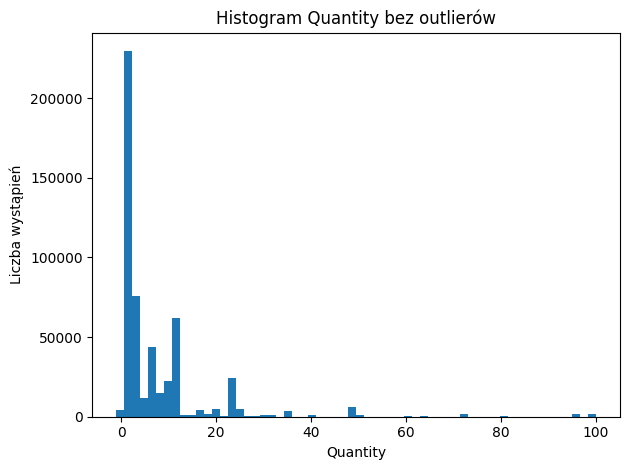

In [16]:
#robię wykres bez dewiantów :)
q = df["Quantity"].dropna()

lo, hi = q.quantile([0.01, 0.99])
q2 = q[(q >= lo) & (q <= hi)]

plt.figure()
plt.hist(q2, bins=60)
plt.xlabel("Quantity")
plt.ylabel("Liczba wystąpień")
plt.title("Histogram Quantity bez outlierów")
plt.tight_layout()
plt.show()

In [ ]:
#Usuwam wartości równe 0 i ujemne bo trudno żeby zamównienie było realne czy poprawne z 0 lub -4
df[df["Quantity"] <= 0]

df = df[df["Quantity"] > 0]
df.size
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [18]:
lo, hi = q.quantile([0.01, 0.99])

df = df[df["Quantity"] > lo]
df = df[df["Quantity"] < hi]
df.size
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


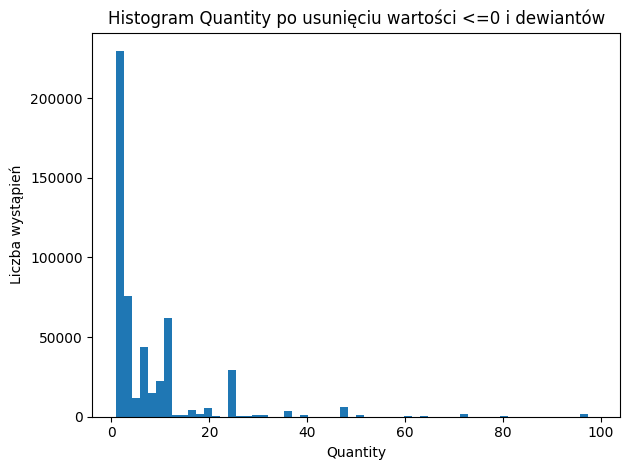

In [19]:
plt.figure()
plt.hist(df["Quantity"], bins=60)
plt.xlabel("Quantity")
plt.ylabel("Liczba wystąpień")
plt.title("Histogram Quantity po usunięciu wartości <=0 i dewiantów")
plt.tight_layout()
plt.show()

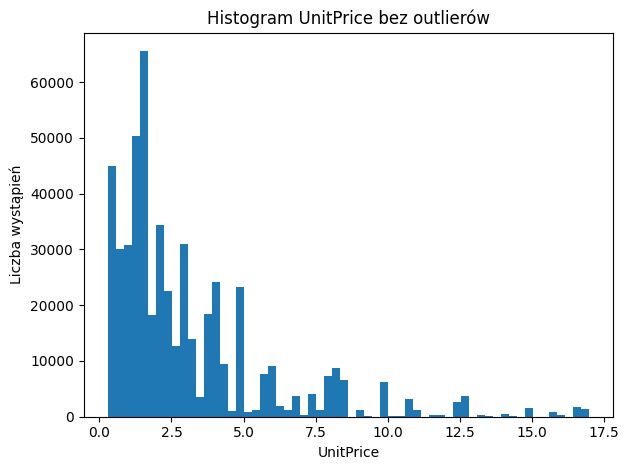

In [20]:
q = df["UnitPrice"].dropna()

lo, hi = q.quantile([0.01, 0.99])
q2 = q[(q >= lo) & (q <= hi)]

plt.figure()
plt.hist(q2, bins=60)
plt.xlabel("UnitPrice")
plt.ylabel("Liczba wystąpień")
plt.title("Histogram UnitPrice bez outlierów")
plt.tight_layout()
plt.show()

In [ ]:
lo, hi = q.quantile([0.01, 0.99])

df = df[df["UnitPrice"] > lo] #większych od najmnijeszej wartości
df = df[df["UnitPrice"] < hi] #mniejsze od największej czyli bez dewiantów
df.size
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


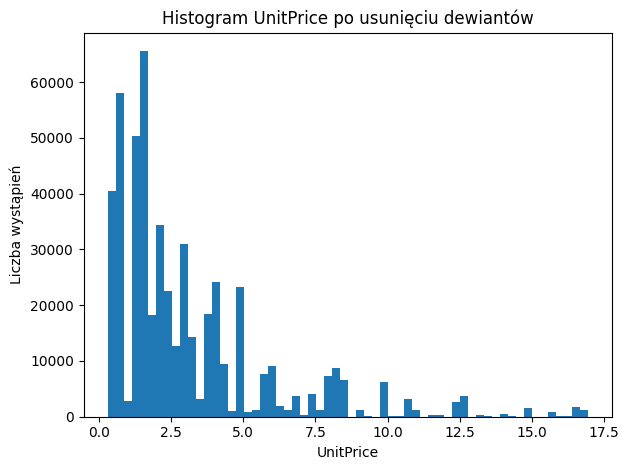

In [22]:
plt.figure()
plt.hist(df["UnitPrice"], bins=60)
plt.xlabel("UnitPrice")
plt.ylabel("Liczba wystąpień")
plt.title("Histogram UnitPrice po usunięciu dewiantów")
plt.tight_layout()
plt.show()

In [23]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"] # robię nową kolumnę z ceną całkowitą
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


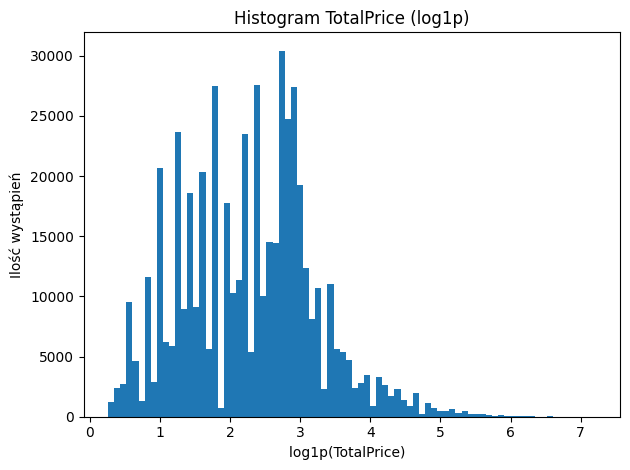

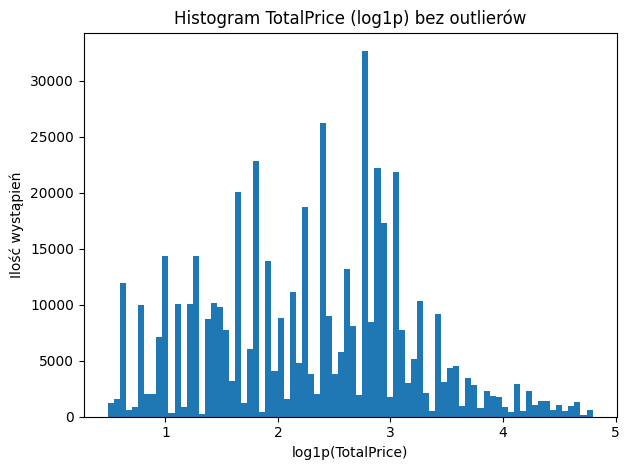

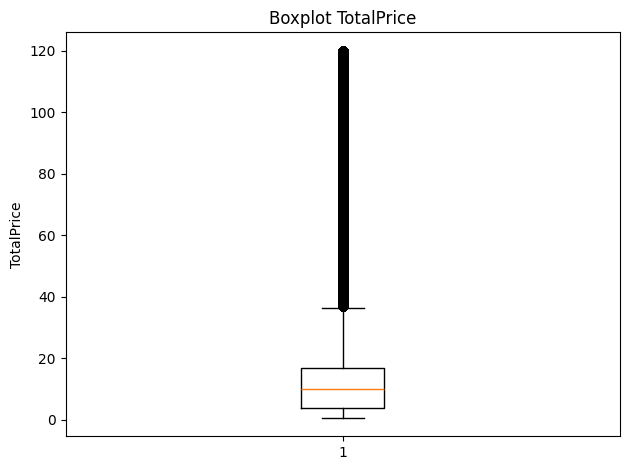

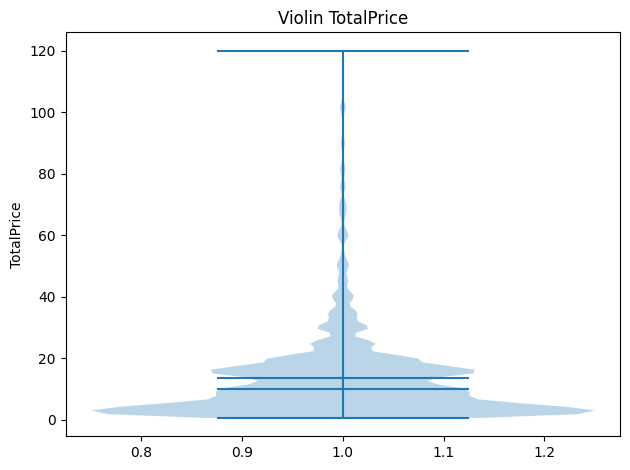

In [ ]:
tp = df["TotalPrice"].replace([np.inf, -np.inf], np.nan).dropna()
tp = tp[tp > 0]  

plt.figure()
plt.hist(np.log1p(tp), bins=80)
plt.xlabel("log1p(TotalPrice)  ")
plt.ylabel("Ilość wystąpień")
plt.title("Histogram TotalPrice (log1p)")
plt.tight_layout()
plt.show()

tp = df["TotalPrice"].replace([np.inf, -np.inf], np.nan).dropna()
tp = tp[tp > 0] 
lo, hi = tp.quantile([0.01, 0.99])
tp2 = tp[(tp >= lo) & (tp <= hi)]

plt.figure()
plt.hist(np.log1p(tp2), bins=80)
plt.xlabel("log1p(TotalPrice)")
plt.ylabel("Ilość wystąpień")
plt.title("Histogram TotalPrice (log1p) bez outlierów")
plt.tight_layout()
plt.show()

plt.figure()
plt.boxplot(tp2.values, vert=True)
plt.ylabel("TotalPrice")
plt.title("Boxplot TotalPrice")
plt.tight_layout()
plt.show()

plt.figure()
plt.violinplot(tp2.values, showmeans=True, showmedians=True)
plt.ylabel("TotalPrice")
plt.title("Violin TotalPrice")
plt.tight_layout()
plt.show()

Budowa szeregu czasowego (TS) — czyszczenie + agregacja dzienna

W tej części przygotowujemy dane do modelowania szeregów czasowych. Najpierw wykonujemy minimalne czyszczenie, aby zostawić tylko transakcje odpowiadające realnej sprzedaży (bez anulacji, zwrotów i rekordów z niepoprawnymi wartościami). Następnie liczymy przychód (Revenue = Quantity × UnitPrice) i agregujemy go do postaci dziennego szeregu czasowego.

Wymuszamy, aby w szeregu znalazł się każdy dzień z badanego okresu. Jeżeli w danym dniu nie było sprzedaży, wpisujemy wartość 0, ponieważ jest to istotna informacja (dzień bez obrotu), a nie brak danych. Dodatkowo tworzymy pomocnicze szeregi dzienne: liczbę zamówień (daily_orders) oraz łączną liczbę sprzedanych sztuk (daily_quantity), które mogą się przydać do dalszej eksploracji lub budowy modeli.

In [ ]:
df_ts = df.copy() # robię kopię aby jakcoś zepusję całoścdanych nie była niezdatna

df_ts["InvoiceDate"] = pd.to_datetime(df_ts["InvoiceDate"], errors="coerce") #sprawdzam czy daty są datetime

df_ts = df_ts.dropna(subset=["InvoiceDate", "InvoiceNo", "Quantity", "UnitPrice"]) #usuwam na wszelki wypadek puste wartości
df_ts = df_ts[~df_ts["InvoiceNo"].astype(str).str.startswith("C", na=False)] #wywalam zwrty (fsktury zaczynają sie na C)
df_ts = df_ts[(df_ts["Quantity"] > 0) & (df_ts["UnitPrice"] > 0)] #zostawiam ilośc większą od zera i ceny większe od 0

df_ts["Revenue"] = df_ts["Quantity"] * df_ts["UnitPrice"] #liczę przychód tranzakcji

daily_revenue = (
    df_ts.set_index("InvoiceDate")["Revenue"]
         .resample("D")
         .sum()
         .asfreq("D", fill_value=0.0)  # brakujące dni = 0 - żeby móc obserwować kiedy nie ma przychodu
) #szereg czasowy dziennego przychodu


daily_orders = (
    df_ts.set_index("InvoiceDate")["InvoiceNo"]
         .resample("D")
         .nunique()
         .asfreq("D", fill_value=0)
) #robiępomocnicze seregi czasowe jak ile amówieńi ile sztuk per dzień

daily_quantity = (
    df_ts.set_index("InvoiceDate")["Quantity"]
         .resample("D")
         .sum()
         .asfreq("D", fill_value=0)
)


print("Zakres:", daily_revenue.index.min().date(), "→", daily_revenue.index.max().date())
print("Dni:", len(daily_revenue))
print("Suma wszystkich przychodów:", round(daily_revenue.sum(), 2))
print("Dni bez przychodu:", int((daily_revenue == 0).sum()))


Zakres: 2010-12-01 → 2011-12-09
Dni: 374
Suma wszystkich przychodów: 7808630.52
Dni bez przychodu: 69


Eksploracja szeregu czasowego: trend, wygładzenie i sezonowość tygodniowa

W tej sekcji wizualizujemy przygotowany dzienny szereg daily_revenue, aby zrozumieć jego zachowanie w czasie.

Surowy wykres dzienny pokazuje ogólny kształt szeregu, możliwe trendy oraz występowanie dni z zerowym przychodem i pojedynczych “pików” (np. zwiększona sprzedaż w wybranych okresach).

Średnie kroczące MA(7) i MA(30) służą do wygładzenia danych:

MA(7) ułatwia zauważenie regularności tygodniowej,

MA(30) pokazuje wolniejsze zmiany i ogólny trend w dłuższym okresie.

Boxplot według dnia tygodnia pozwala ocenić, czy istnieje sezonowość tygodniowa (np. niższe wartości w weekendy). Dzięki temu możemy uzasadnić użycie modeli uwzględniających sezonowość o okresie 7 dni (np. ETS z seasonal_periods=7 lub SARIMA z sezonem s=7).

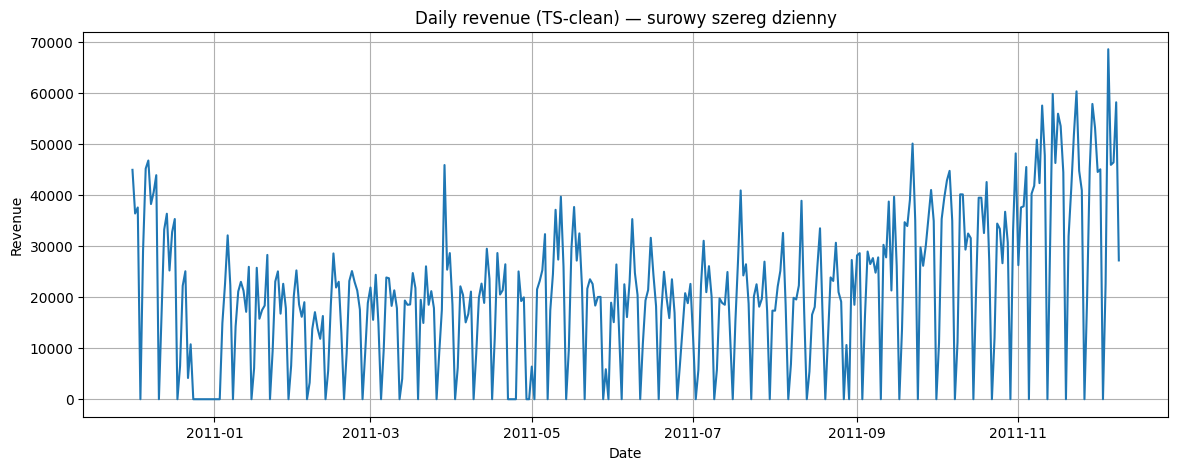

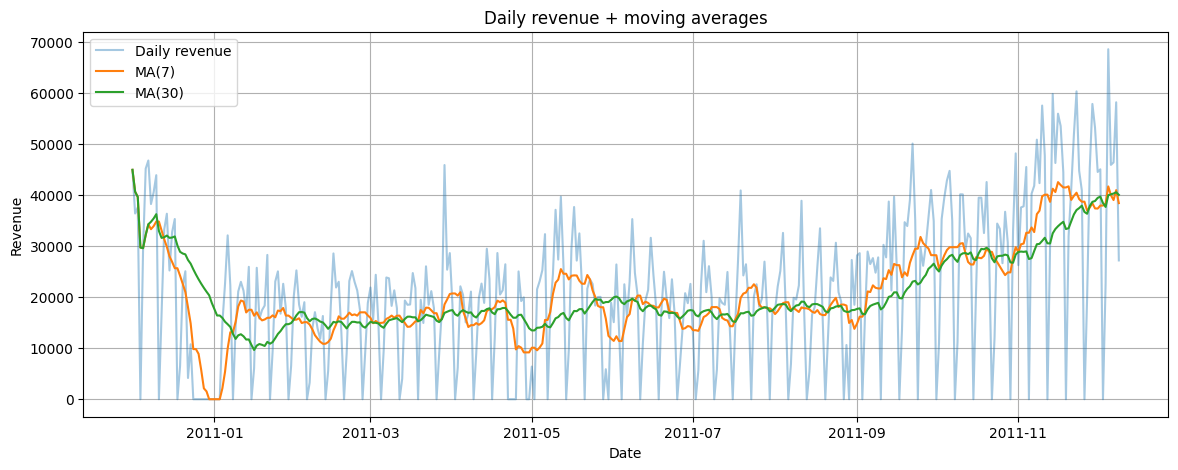

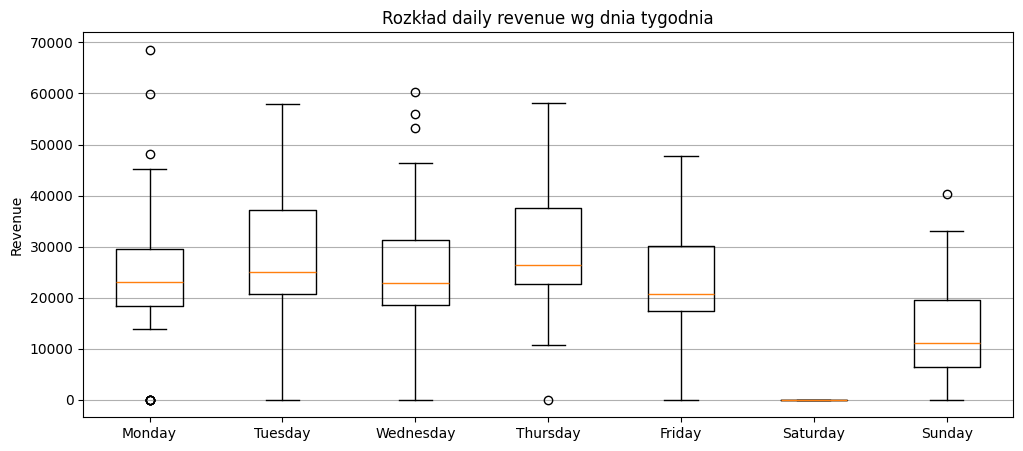

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(daily_revenue)
plt.title("Daily revenue (TS-clean) — surowy szereg dzienny")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

# definiuje średnie kroczące: 7 dni i 30 dni
ma7 = daily_revenue.rolling(window=7, min_periods=1).mean() #rolling robienia konkretnych przedziałow
ma30 = daily_revenue.rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_revenue, alpha=0.4, label="Daily revenue")
plt.plot(ma7, label="MA(7)")
plt.plot(ma30, label="MA(30)")
plt.title("Daily revenue + moving averages")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

# robię boxplot wg dnia tygodnia
dow = daily_revenue.copy()
dow.index = pd.to_datetime(dow.index)
dow_df = pd.DataFrame({"revenue": dow.values, "dow": dow.index.day_name()})

# Ustawiam kolejność dni tygodnia
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_df["dow"] = pd.Categorical(dow_df["dow"], categories=order, ordered=True)

plt.figure(figsize=(12, 5))
plt.boxplot([dow_df.loc[dow_df["dow"] == d, "revenue"] for d in order], tick_labels=order)
plt.title("Rozkład daily revenue wg dnia tygodnia")
plt.ylabel("Revenue")
plt.grid(True, axis="y")
plt.show()


Test stacjonarności (ADF) — przygotowanie pod SARIMA

W tej sekcji sprawdzamy, czy nasz szereg czasowy jest stacjonarny, czyli czy jego własności (średnia, wariancja) są w przybliżeniu stałe w czasie. Jest to szczególnie ważne dla modeli z rodziny ARIMA/SARIMA, które zakładają stacjonarność (lub wymagają transformacji, aby ją uzyskać).

ADF (Augmented Dickey–Fuller test)
Wykonujemy test ADF dla kilku wariantów szeregu:

daily_revenue (surowy szereg),

log1p(daily_revenue) — transformacja logarytmiczna odporna na zera (stabilizacja wariancji),

diff1 — różnicowanie 1. rzędu (usuwanie trendu),

diff7 — różnicowanie sezonowe o okresie 7 dni (usuwanie sezonowości tygodniowej),

diff1 + diff7 — połączenie obu (trend + sezonowość tygodniowa).

Dla każdego wariantu generujemy raport zawierający m.in. statystykę testową, p-value i wartości krytyczne. Interpretacja jest prosta:

jeśli p < 0.05, odrzucamy hipotezę o niestacjonarności → szereg traktujemy jako stacjonarny,

jeśli p ≥ 0.05, nie mamy podstaw do odrzucenia hipotezy → szereg jest niestacjonarny i wymaga transformacji.

Test wykonujemy w dwóch konfiguracjach regresji:

c (stała),

ct (stała + trend), co bywa sensowne, gdy w danych występuje wyraźny trend.

Wykresy transformacji
Rysujemy przebieg szeregu surowego oraz jego transformacji (logarytm, różnicowania), aby wizualnie ocenić wpływ przekształceń i lepiej zrozumieć, dlaczego dana wersja szeregu może być bardziej stacjonarna.


 ADF TEST: daily_revenue
regression: c | autolag: AIC
Test statistic: -2.157621
p-value: 0.221984
Used lags: 16
N observations: 357
Critical values:
  1%: -3.448801
  5%: -2.869670
  10%: -2.571101
Best IC (autolag): 7402.692754
Wniosek (p>=0.05): brak podstaw do odrzucenia H0 → szereg niestacjonarny (unit root).

 ADF TEST: log1p(daily_revenue)
regression: c | autolag: AIC
Test statistic: -4.480834
p-value: 0.000212929
Used lags: 16
N observations: 357
Critical values:
  1%: -3.448801
  5%: -2.869670
  10%: -2.571101
Best IC (autolag): 1487.678854
Wniosek (p<0.05): odrzucamy H0 - szereg prawdopodobnie stacjonarny.

 ADF TEST: diff1(daily_revenue)
regression: c | autolag: AIC
Test statistic: -5.394954
p-value: 3.47085e-06
Used lags: 15
N observations: 357
Critical values:
  1%: -3.448801
  5%: -2.869670
  10%: -2.571101
Best IC (autolag): 7384.616710
Wniosek (p<0.05): odrzucamy H0 - szereg prawdopodobnie stacjonarny.

 ADF TEST: diff7(daily_revenue)
regression: c | autolag: AIC
Test s

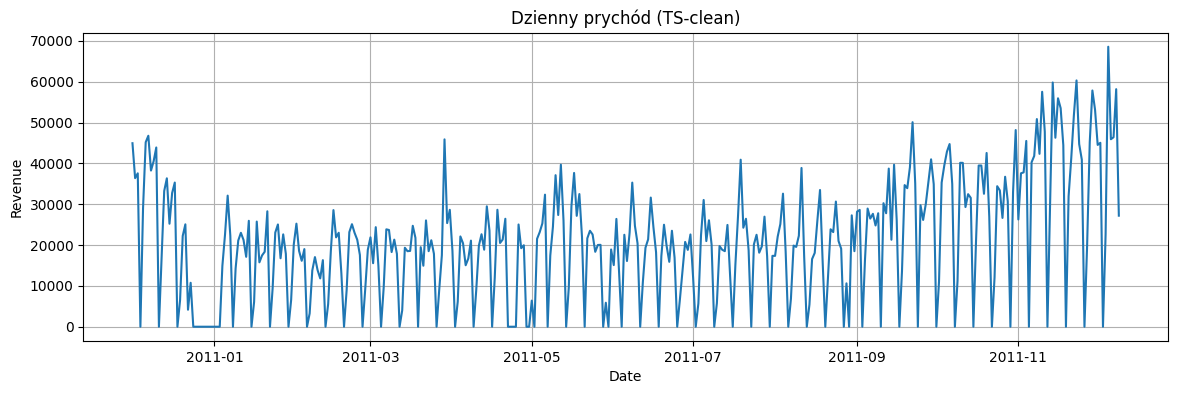

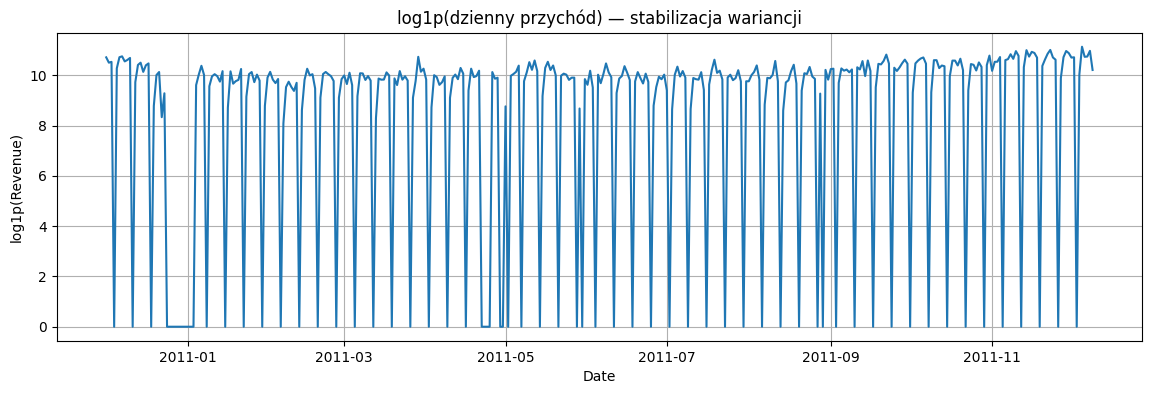

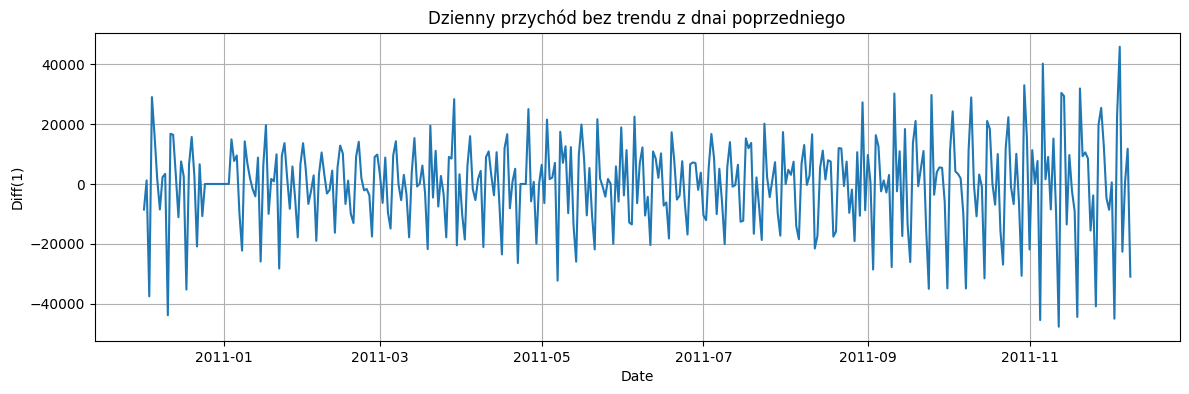

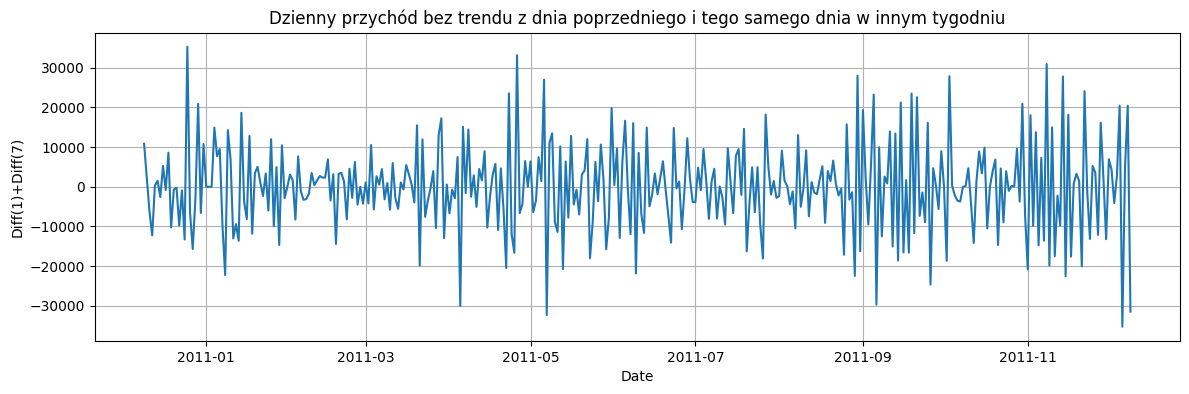

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_report(series: pd.Series, name: str, regression: str = "c", autolag: str = "AIC"):
    """Wypisuje pełny raport ADF."""
    s = series.dropna().astype(float)
    result = adfuller(s, regression=regression, autolag=autolag)
    test_stat, p_value, used_lag, nobs, crit_values, icbest = result[0], result[1], result[2], result[3], result[4], result[5]

    print(f"\n ADF TEST: {name}")
    print(f"regression: {regression} | autolag: {autolag}")
    print(f"Test statistic: {test_stat:.6f}")
    print(f"p-value: {p_value:.6g}")
    print(f"Used lags: {used_lag}")
    print(f"N observations: {nobs}")
    print("Critical values:")
    for k, v in crit_values.items():
        print(f"  {k}: {v:.6f}")
    print(f"Best IC (autolag): {icbest:.6f}")

    if p_value < 0.05:
        print("Wniosek (p<0.05): odrzucamy H0 - szereg prawdopodobnie stacjonarny.")
    else:
        print("Wniosek (p>=0.05): brak podstaw do odrzucenia H0 → szereg niestacjonarny (unit root).")

# przygotowanie wariantów szeregu 
y = daily_revenue.astype(float)

y_log = np.log1p(y) # logarytmizuje dane, po to aby ustabilizować wariancje i skośność danych
y_diff1 = y.diff(1) # sprawdzam czy dane z dniana dzień sa ze sobą powiązane
y_seas7 = y.diff(7) # sprawdzam czy dane z tego dnia tydzień wcześniej wpływają na ten konkretny dzień
y_diff1_seas7 = y.diff(1).diff(7) # sprawdzam czy wpłływ ma i dzień w zeszłym tygodniu i dzień poprzedzający

# robię z ADF 2 raporty
# c = stała, ct = stała + trend
for reg in ["c", "ct"]:
    adf_report(y, "daily_revenue", regression=reg)
    adf_report(y_log, "log1p(daily_revenue)", regression=reg)
    adf_report(y_diff1, "diff1(daily_revenue)", regression=reg)
    adf_report(y_seas7, "diff7(daily_revenue)", regression=reg)
    adf_report(y_diff1_seas7, "diff1+diff7(daily_revenue)", regression=reg)

# Wykresy diagnostyczne
plt.figure(figsize=(14, 4))
plt.plot(y)
plt.title("Dzienny prychód (TS-clean)")
plt.xlabel("Date"); plt.ylabel("Revenue")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_log)
plt.title("log1p(dzienny przychód) — stabilizacja wariancji")
plt.xlabel("Date"); plt.ylabel("log1p(Revenue)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_diff1)
plt.title("Dzienny przychód bez trendu z dnai poprzedniego")
plt.xlabel("Date"); plt.ylabel("Diff(1)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_diff1_seas7)
plt.title("Dzienny przychód bez trendu z dnia poprzedniego i tego samego dnia w innym tygodniu")
plt.xlabel("Date"); plt.ylabel("Diff(1)+Diff(7)")
plt.grid(True)
plt.show()


Model 1: ETS (Holt–Winters) — budowa prognozy i ocena jakości na zbiorze testowym

W tej sekcji budujemy pierwszy model prognostyczny dla dziennego przychodu: Exponential Smoothing (Holt–Winters / ETS). Jest to klasyczna metoda dla szeregów czasowych, która potrafi jednocześnie modelować poziom, trend oraz sezonowość.

Podział danych na train/test
Dzielimy szereg chronologicznie: większość danych służy do uczenia modelu, a ostatnie 30 dni zostawiamy jako zbiór testowy. Taki podział symuluje realny scenariusz prognozowania “w przyszłość” na podstawie danych historycznych.

Dopasowanie modelu ETS (Holt–Winters)
Konfigurujemy model tak, aby odpowiadał temu, co widzieliśmy w eksploracji:

trend="add" — uwzględniamy trend, bo poziom przychodu zmienia się w czasie,

seasonal="add" i seasonal_periods=7 — uwzględniamy sezonowość tygodniową, ponieważ dane mają wyraźny rytm tygodnia (np. różnice między dniami roboczymi a weekendami).

Model sam dobiera parametry wygładzania w procesie optymalizacji (optimized=True), a initialization_method="estimated" stabilizuje inicjalizację składowych.

Prognoza na okres testowy
Generujemy prognozę dokładnie na tyle dni, ile jest w zbiorze testowym, aby porównać przewidywania z rzeczywistymi wartościami.

Ocena jakości prognozy (metryki błędu)
Liczymy trzy podstawowe metryki:

MAE — średni błąd bezwzględny (łatwy do interpretacji w jednostkach przychodu),

MSE — średni błąd kwadratowy (mocniej karze duże pomyłki),

RMSE — pierwiastek z MSE (również w jednostkach przychodu, często używany w porównaniach modeli).

Dodatkowo raportujemy bias (mean(Test - Forecast)), który mówi, czy model ma tendencję do systematycznego zaniżania lub zawyżania prognoz.

Wizualna ocena dopasowania
Rysujemy wykres train/test/forecast, aby sprawdzić:

czy prognoza trafia w ogólny poziom,

czy odwzorowuje sezonowość tygodniową,

czy nie “spóźnia się” względem zmian.

Histogram błędów
Na koniec patrzymy na rozkład błędów. Jeżeli błędy są w miarę symetryczne wokół zera i bez skrajnych odchyleń, oznacza to, że model nie ma silnych systematycznych pomyłek (np. ciągłego niedoszacowania).

Dni w treningu: 2010-12-01 - 2011-11-09 | n= 344
Dni w testach: 2011-11-10 - 2011-12-09 | n= 30

ETS (Holt-Winters) summary
                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Revenue   No. Observations:                  344
Model:             ExponentialSmoothing   SSE                    16578421113.706
Optimized:                         True   AIC                           6107.610
Trend:                         Additive   BIC                           6149.857
Seasonal:                      Additive   AICC                          6108.713
Seasonal Periods:                     7   Date:                 Wed, 28 Jan 2026
Box-Cox:                          False   Time:                         22:53:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-----------------------------------------------------------------

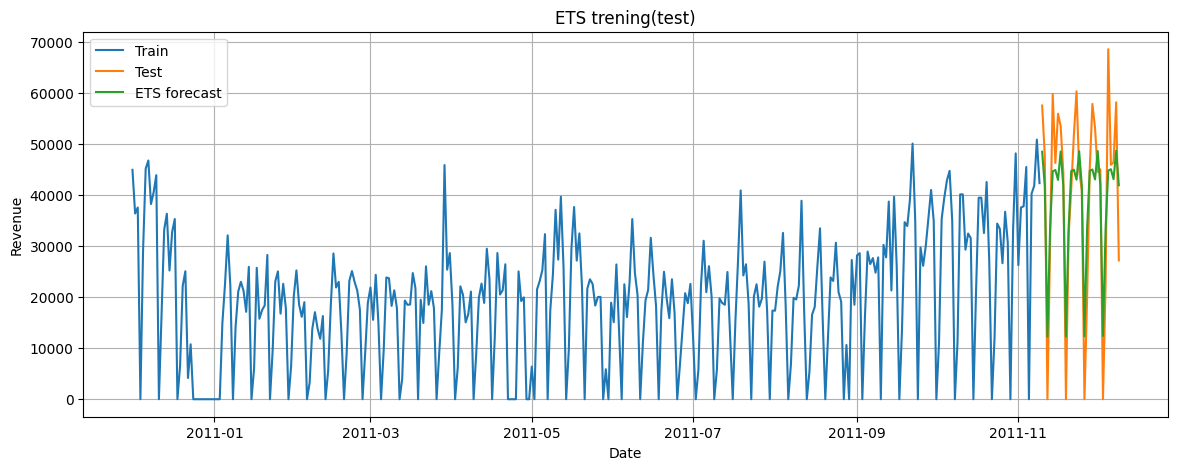

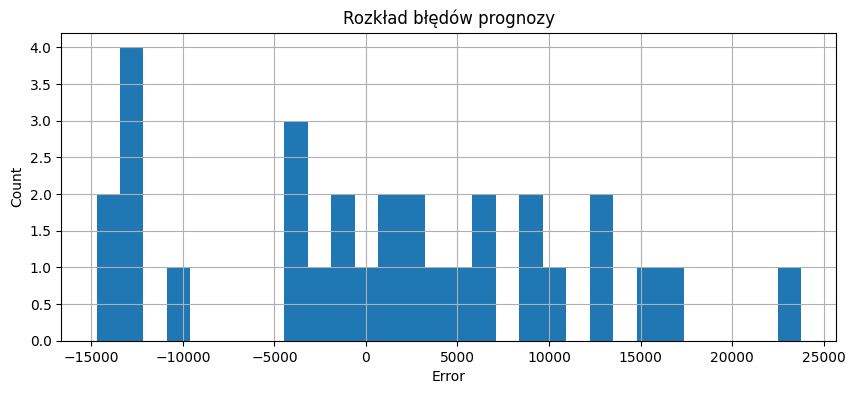

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y = daily_revenue.astype(float) #rzutuje do liczby zmienneoprzecinkowej

TEST_DAYS = 30
train = y.iloc[:-TEST_DAYS] #robię dane treningowe
test  = y.iloc[-TEST_DAYS:] #robię dane testowe

print("Dni w treningu:", train.index.min().date(), "-", train.index.max().date(), "| n=", len(train))
print("Dni w testach:", test.index.min().date(), "-", test.index.max().date(), "| n=", len(test))

ets = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=7,
    initialization_method="estimated"  # tworze model ets
)

ets_fit = ets.fit(optimized=True) #trenuje ten model

print("\nETS (Holt-Winters) summary")
print(ets_fit.summary()) #podsumowanie modelu

forecast = ets_fit.forecast(len(test))
forecast.name = "ETS forecast" #generuję prognozę nakolejne 30 dni - sprawdzam model

errors = test - forecast # czy przewidywania sie sprawdziły
mae = np.mean(np.abs(errors)) #średnia wartość bezwględnabłędu
mse = np.mean(errors**2) #średni błąd kwadratowy - dużewpadki
rmse = np.sqrt(mse) #bardziej wrażliwa opcja na duże błędy

print("\nETS metryki po teście")
print(f"MAE : {mae:,.2f}")
print(f"MSE : {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")

#wizualizacja jak badzo pokrywają sie moje przewidywania
plt.figure(figsize=(14, 5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.plot(forecast.index, forecast.values, label="ETS forecast")
plt.title("ETS trening(test)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

#wykres pokazujący jakie błędy popełnia model
plt.figure(figsize=(10, 4))
plt.hist(errors.dropna(), bins=30)
plt.title("Rozkład błędów prognozy")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()


Model 2: SARIMA — dobór parametrów (grid search) i ocena prognozy na zbiorze testowym

W tej sekcji budujemy drugi model prognostyczny: SARIMA (Seasonal ARIMA). Jest to klasyczny model statystyczny do szeregów czasowych, który oprócz części “zwykłej” ARIMA potrafi uwzględniać sezonowość (u nas tygodniową).

Podział danych na train/test
Tak jak wcześniej, zostawiamy ostatnie 30 dni jako zbiór testowy, aby ocenić jakość prognoz na “niewidzianych” danych.

Ustalenie różnicowań na podstawie ADF
Na podstawie testów stacjonarności przyjmujemy:

d = 1 (różnicowanie usuwa trend),

D = 1 oraz s = 7 (różnicowanie sezonowe usuwa sezonowość tygodniową),
co jest typowym punktem startowym dla danych z rytmem tygodnia.

Grid search (mała siatka)
Ponieważ parametry SARIMA (p, q, P, Q) nie są oczywiste, przeszukujemy niewielką siatkę wartości:

p, q w zakresie 0–2,

P, Q w zakresie 0–1,
przy stałych d=1, D=1, s=7.

Dla każdej konfiguracji dopasowujemy model na train, generujemy prognozę na test i zapisujemy:

AIC i BIC (kryteria dopasowania z karą za złożoność),

MAE i RMSE (jakość prognozy na zbiorze testowym),

Bias (czy model ma tendencję do zaniżania lub zawyżania prognoz).

Niektóre konfiguracje mogą się nie dopasować (problemy numeryczne) — takie przypadki są pomijane.

Wybór najlepszego modelu i raport statystyczny
Modele sortujemy głównie po AIC (niższe = lepiej), a RMSE traktujemy jako dodatkowy tie-break. Następnie dopasowujemy wybrany najlepszy model ponownie, aby uzyskać pełne podsumowanie (summary) i czytelnie zaprezentować parametry.

Ocena jakości i wizualizacja prognozy
Dla najlepszego modelu raportujemy metryki błędu (MAE/MSE/RMSE/Bias) oraz rysujemy wykres train/test/forecast. Na koniec oglądamy histogram błędów, aby sprawdzić, czy pomyłki są w miarę symetryczne i czy nie pojawiają się skrajne odchylenia.

Zakres treningowy dni: 2010-12-01 - 2011-11-09 | n= 344
Test  rangeakres testowy dni: 2011-11-10 - 2011-12-09 | n= 30

10 najlepszych modeli wg AIC i RMSE:


,order,seasonal_order,AIC,BIC,MAE,RMSE,Bias
0,"(0, 1, 2)","(0, 1, 1, 7)",6748.692700,6767.627187,8947.633629,10661.305354,-3702.232409
1,"(2, 1, 2)","(1, 1, 1, 7)",6749.213108,6779.508287,8285.923931,9880.986202,-2123.239829
2,"(0, 1, 2)","(1, 1, 1, 7)",6750.467396,6773.188780,8998.082899,10714.087156,-3810.151019
3,"(1, 1, 2)","(0, 1, 1, 7)",6752.667175,6775.388559,14079.820859,17239.207132,-12072.393759
4,"(2, 1, 2)","(0, 1, 1, 7)",6754.170338,6780.678620,13946.116435,17056.445309,-11900.790106
5,"(1, 1, 2)","(1, 1, 1, 7)",6754.302522,6780.810804,14632.290560,17871.432737,-12766.387694
6,"(0, 1, 1)","(0, 1, 1, 7)",6774.409935,6789.569775,12209.072687,14946.351797,-9502.869284
7,"(1, 1, 1)","(0, 1, 1, 7)",6775.497583,6794.447384,12288.273115,15022.387002,-9657.627303
8,"(2, 1, 1)","(0, 1, 1, 7)",6775.608976,6798.348737,12155.653580,14860.483669,-9485.327956
9,"(0, 1, 1)","(1, 1, 1, 7)",6775.919410,6794.869211,12632.494309,15396.208046,-10031.446590



Najlepsza SARIMA
order= (2, 1, 2)
seasonal_order= (1, 1, 1, 7)
AIC=6749.21 | BIC=6779.51 | MAE=8285.92 | RMSE=9880.99 | Bias=-2123.24

SARIMA summary (best)
                                      SARIMAX Results                                      
Dep. Variable:                             Revenue   No. Observations:                  344
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -3366.607
Date:                             Wed, 28 Jan 2026   AIC                           6749.213
Time:                                     23:20:55   BIC                           6779.508
Sample:                                 12-01-2010   HQIC                          6761.303
                                      - 11-09-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

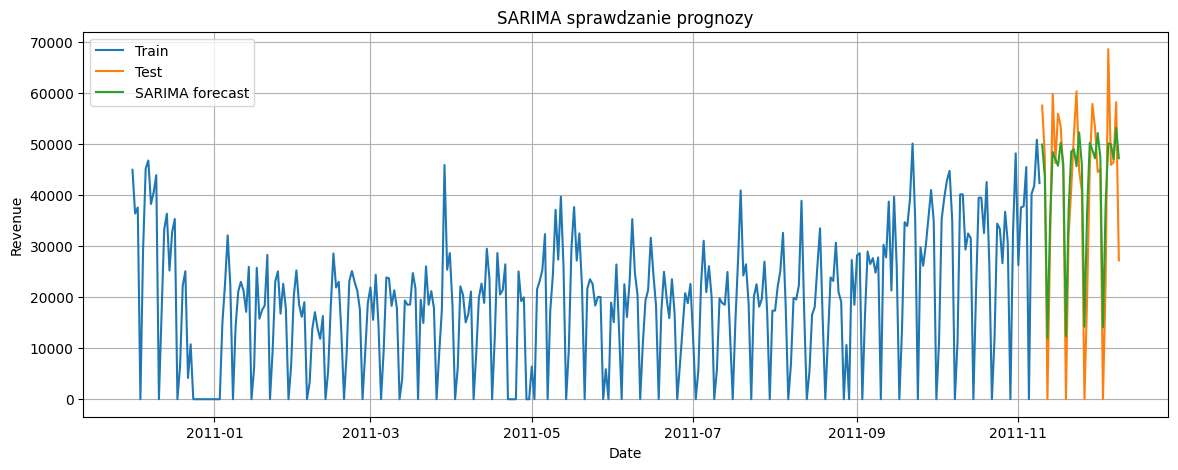

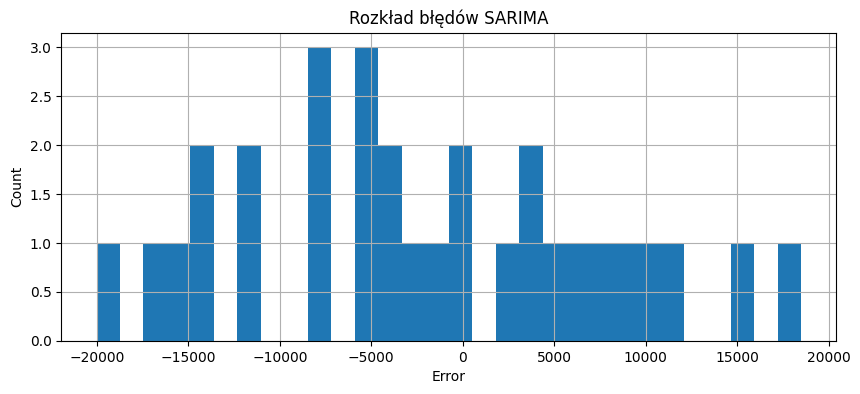

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

y = daily_revenue.astype(float)

TEST_DAYS = 30
train = y.iloc[:-TEST_DAYS]
test  = y.iloc[-TEST_DAYS:]

print("Zakres treningowy dni:", train.index.min().date(), "-", train.index.max().date(), "| n=", len(train))
print("Test  rangeakres testowy dni:", test.index.min().date(),  "-", test.index.max().date(),  "| n=", len(test))

d, D, s = 1, 1, 7 #parametry dla Sarimy d pływ dnia na dzień, s wpływ dnia z poprzedniego tygodnia na ten tydzień, D ile razy usuwamy sezownowść

p_values = [0, 1, 2]
q_values = [0, 1, 2]
P_values = [0, 1]
Q_values = [0, 1] #siatka paratrów aby wybrać najlepsze dla tego modelu 

warnings.filterwarnings("ignore") #ignorujęostrzeżenia

results = []

def compute_metrics(y_true, y_pred): #funkcja wylicza błędy po testowaniu
    err = (y_true - y_pred).dropna()
    mae = float(np.mean(np.abs(err)))
    mse = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    bias = float(np.mean(err))
    return mae, mse, rmse, bias

#przeszukuje siatkę parametów
for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, d, q)
                seasonal_order = (P, D, Q, s)

                try:
                    model = SARIMAX(
                        train,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend="c",
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    fit = model.fit(disp=False)

                    
                    fcst = fit.get_forecast(steps=len(test)).predicted_mean
                    fcst = fcst.clip(lower=0.0)  

                    mae, mse, rmse, bias = compute_metrics(test, fcst)

                    results.append({
                        "order": order,
                        "seasonal_order": seasonal_order,
                        "AIC": fit.aic,
                        "BIC": fit.bic,
                        "MAE": mae,
                        "RMSE": rmse,
                        "Bias": bias
                    })

                except Exception as e:
                    # niektóre konfiguracje mogą nie przejść — pomijam
                    continue

results_df = pd.DataFrame(results).sort_values(["AIC", "RMSE"], ascending=[True, True]).reset_index(drop=True) #ubieramy to w tabelkę

print("\n10 najlepszych modeli wg AIC i RMSE:") #parametru poprawności i parametru błedu
display(results_df.head(10))

best = results_df.iloc[1] #wybiram najlepszy model (bo nwm czemu ale pozyja 2 lepsza od 1)
best_order = tuple(best["order"]) #najlepsze p,d,q
best_seasonal_order = tuple(best["seasonal_order"])# najepsze P, D, Q

print("\nNajlepsza SARIMA")
print("order=", best_order)
print("seasonal_order=", best_seasonal_order)
print(f"AIC={best['AIC']:.2f} | BIC={best['BIC']:.2f} | MAE={best['MAE']:.2f} | RMSE={best['RMSE']:.2f} | Bias={best['Bias']:.2f}")

#ustawiam model na najlepszych parametrach dla łatwiejszego wyświetlania summary
best_model = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_fit = best_model.fit(disp=False) #trenuje najlepszy model

print("\nSARIMA summary (best)")
print(best_fit.summary())

#prognoza na 30 dni jak wcześniej do testów
best_fcst = best_fit.get_forecast(steps=len(test)).predicted_mean.clip(lower=0.0)
best_fcst.name = "SARIMA forecast"

# sprawdzam metryki po testach
err = (test - best_fcst).dropna()
mae = float(np.mean(np.abs(err)))
mse = float(np.mean(err**2))
rmse = float(np.sqrt(mse))
bias = float(np.mean(err))

print("\nMetryki najlepszej SARIMy po teście")
print(f"MAE : {mae:,.2f}")
print(f"MSE : {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"Bias (mean(Test-Fcst)): {bias:,.2f}")


plt.figure(figsize=(14, 5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.plot(best_fcst.index, best_fcst.values, label="SARIMA forecast")
plt.title("SARIMA sprawdzanie prognozy")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
plt.hist(err, bins=30)
plt.title("Rozkład błędów SARIMA")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()


Walidacja czasowa (walk-forward CV) — porównanie modeli na wielu oknach czasu

W tej sekcji przeprowadzono walidację krzyżową dla szeregów czasowych w wariancie walk-forward (expanding window). Jest to kluczowy etap analizy, ponieważ pojedynczy podział danych na zbiór treningowy i testowy (np. ostatnie 30 dni) może prowadzić do przypadkowo zawyżonej lub zaniżonej oceny jakości modelu. Walidacja walk-forward pozwala ocenić, jak stabilnie modele prognozują w różnych momentach historii danych.

Dlaczego nie klasyczna walidacja k-fold?

W przypadku szeregów czasowych nie można stosować klasycznej walidacji k-fold, ponieważ losowe mieszanie obserwacji prowadziłoby do naruszenia chronologii danych. W takim scenariuszu model mógłby „zobaczyć przyszłość” podczas uczenia, co skutkowałoby wyciekiem informacji (data leakage) i nieuczciwą oceną jakości prognoz.

Zamiast tego zastosowano podejście walk-forward, w którym:

model uczony jest na danych od początku szeregu do określonej daty,

prognozowane są kolejne horizon dni w przyszłości,

zbiór treningowy jest następnie wydłużany, a cały proces powtarzany.

Ustawienia walidacji walk-forward

Walidację przeprowadzono z następującymi parametrami:

horizon = 30 – w każdym foldzie prognozowane są kolejne 30 dni,

initial_train = 250 – pierwsze 250 dni stanowi minimalny zbiór treningowy, zapewniający wystarczającą ilość danych do estymacji modeli,

step = 30 – punkt podziału train/test przesuwany jest co 30 dni, co pozwala uzyskać kolejne, częściowo nakładające się foldy.

Zastosowany schemat odpowiada expanding window, w którym zbiór treningowy rośnie wraz z upływem czasu, co odzwierciedla realistyczny scenariusz biznesowy polegający na sukcesywnym gromadzeniu danych historycznych.

Modele porównywane w walidacji

W każdym foldzie dopasowywane i oceniane były dwa modele:

ETS (Holt–Winters) – model wygładzania wykładniczego z trendem addytywnym i sezonowością tygodniową,

SARIMA – model autoregresyjny z różnicowaniem i sezonowością tygodniową, z parametrami ustalonymi wcześniej jako najlepsze.

Każdy model był trenowany wyłącznie na danych dostępnych do danego momentu czasu, a następnie wykorzystywany do prognozowania przyszłego okresu testowego.

Metryki liczone w każdym foldzie

Dla każdego modelu i każdego folda obliczano następujące miary jakości prognoz:

MAE (Mean Absolute Error) – średni błąd bezwzględny,

RMSE (Root Mean Squared Error) – miara silniej penalizująca duże błędy prognozy,

Bias – średni błąd (Test − Forecast), informujący o systematycznym przeszacowaniu lub niedoszacowaniu prognoz.

Wyniki wszystkich foldów zostały zapisane w tabeli cv, co umożliwiło analizę zmienności jakości prognoz w czasie.

,train_end,test_start,test_end,train_n,ETS_MAE,ETS_MSE,ETS_RMSE,ETS_Bias,SARIMA_order,SARIMA_seasonal,SARIMA_MAE,SARIMA_MSE,SARIMA_RMSE,SARIMA_Bias
0,2011-08-07,2011-08-08,2011-09-06,250,4794.960430,4.592174e+07,6776.558234,2420.512329,"(2, 1, 2)","(1, 1, 1, 7)",4382.178996,3.960294e+07,6293.086862,1686.354116
1,2011-09-06,2011-09-07,2011-10-06,280,8524.784235,1.005240e+08,10026.167939,6598.412425,"(2, 1, 2)","(1, 1, 1, 7)",41621.359192,2.341115e+09,48385.066003,-41621.359192
2,2011-10-06,2011-10-07,2011-11-05,310,7084.784536,7.147698e+07,8454.405668,-3997.533896,"(2, 1, 2)","(1, 1, 1, 7)",16294.975062,3.387478e+08,18405.101538,-16157.267062
3,2011-11-05,2011-11-06,2011-12-05,340,11119.408271,1.767039e+08,13293.002953,9166.621795,"(2, 1, 2)","(1, 1, 1, 7)",9051.716769,1.100680e+08,10491.327631,-269.680023



=== Walk-forward CV summary (ETS vs SARIMA) ===


,MAE_mean,RMSE_mean,Bias_mean,RMSE_median
ETS,7880.984368,9637.533698,3547.003163,9240.286803
SARIMA,17837.557505,20893.645508,-14090.488040,14448.214584


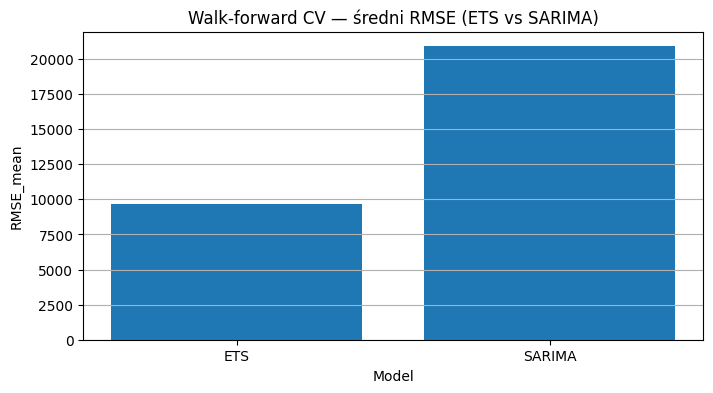

In [47]:
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")   

horizon = 30 # ile dni prognozujemy w każdym foldzie (zawsze 30 dni "w przyszłość")
initial_train = 250  # ile pierwszych dni bierzemy jako startowy train (żeby model miał dane)
step = 30 # co ile dni przesuwamy granicę train/test (tu: co miesiąc)


def compute_metrics(y_true: pd.Series, y_pred: pd.Series):
    # y_true = prawdziwe wartości (test), y_pred = prognoza

    y_pred = pd.Series(y_pred, index=y_pred.index).reindex(y_true.index)
    # wyrównujemy indeksy dat:
    # czasem pred ma inne daty lub braki — reindex wymusza tę samą oś czasu co y_true

    err = (y_true - y_pred).dropna()
    # błąd = prawda - prognoza
    # dropna usuwa ewentualne NaN (np. gdy coś się nie dopasowało)

    mae = float(np.mean(np.abs(err)))
    # MAE = średni błąd bezwzględny: "średnio o ile się mylę" w jednostkach revenue

    mse = float(np.mean(err**2))
    # MSE = średni błąd kwadratowy: mocniej karze duże pomyłki

    rmse = float(np.sqrt(mse))
    # RMSE = pierwiastek z MSE: znowu w jednostkach revenue, ale nadal karze duże błędy

    bias = float(np.mean(err))
    # Bias = średni błąd (kierunek pomyłki):
    #  >0 → model zaniża (bo prawda - prognoza dodatnia)
    #  <0 → model zawyża

    return mae, mse, rmse, bias
    # zwracamy 4 liczby

def ets_forecast(train: pd.Series, horizon: int):
    # budujemy model ETS na train i robimy prognozę na "horizon" dni

    ets = ExponentialSmoothing(
        train,                       # dane treningowe
        trend="add",                 # trend addytywny (poziom rośnie/spada o stałe wartości)
        seasonal="add",              # sezonowość addytywna (wahania mają w miarę stałą amplitudę)
        seasonal_periods=7,          # sezon = 7 dni (tydzień)
        initialization_method="estimated"  # model sam dobiera wartości startowe
    )

    ets_fit = ets.fit(optimized=True)
    # dopasowujemy parametry wygładzania (automatyczna optymalizacja)

    pred = ets_fit.forecast(horizon).clip(lower=0.0)
    # prognoza na horizon dni
    # clip(lower=0.0) bo revenue nie powinno być ujemne

    return pred
    # zwracamy prognozę jako pd.Series (z datami)


def sarima_forecast_fixed(train: pd.Series, horizon: int, order, seasonal_order):
    # dopasowujemy SARIMA o zadanych parametrach i prognozujemy horizon dni

    fit = SARIMAX(
        train,                       # dane treningowe
        order=order,                 # (p,d,q)
        seasonal_order=seasonal_order,# (P,D,Q,s)
        trend="c",                   # stała (intercept)
        enforce_stationarity=False,  # nie wymuszamy stacjonarności (łatwiej dopasować)
        enforce_invertibility=False  # nie wymuszamy odwracalności (łatwiej dopasować)
    ).fit(disp=False)
    # fit() dopasowuje parametry; disp=False = bez logów

    pred = fit.get_forecast(steps=horizon).predicted_mean.clip(lower=0.0)
    # forecast na horizon dni (punktowa prognoza)
    # clip bo revenue nie może być < 0

    return pred
    # zwracamy prognozę jako pd.Series


best = results_df.iloc[1]
order = tuple(best["order"])
seasonal_order = tuple(best["seasonal_order"])


# bierzemy parametry SARIMA z wcześniejszego kroku (muszą istnieć)


rows = []                 # tu będziemy zbierać wyniki z każdego folda
start = initial_train     # startowy punkt podziału train/test

while start + horizon <= len(y):
    # pętla idzie dopóki da się zrobić pełne 30 dni testu

    train = y.iloc[:start]
    # train = od początku szeregu do "start" (okno rośnie)

    test = y.iloc[start:start + horizon]
    # test = kolejne 30 dni po train (symulowana przyszłość)

    row = {
        "train_end": train.index[-1],  # ostatnia data train
        "test_start": test.index[0],   # pierwsza data testu
        "test_end": test.index[-1],    # ostatnia data testu
        "train_n": len(train),         # ile dni ma train w tym foldzie
    }
    # przygotowujemy słownik na wyniki dla tego folda

    # ETS
    try:
        pred_ets = ets_forecast(train, horizon)
        # robimy prognozę ETS na 30 dni

        row["ETS_MAE"], row["ETS_MSE"], row["ETS_RMSE"], row["ETS_Bias"] = compute_metrics(test, pred_ets)
        # liczymy metryki i zapisujemy do wiersza
    except Exception as e:
        # jak ETS się wywali (rzadko), to wpisujemy NaN i zapisujemy błąd
        row["ETS_MAE"] = row["ETS_MSE"] = row["ETS_RMSE"] = row["ETS_Bias"] = np.nan
        row["ETS_err"] = str(e)

    # SARIMA (na stałych parametrach)
    try:
        pred_sar = sarima_forecast_fixed(train, horizon, order, seasonal_order)
        # prognoza SARIMA na 30 dni

        row["SARIMA_order"] = str(order)
        # zapisujemy parametry (żeby było jasne, czym prognozowałeś)

        row["SARIMA_seasonal"] = str(seasonal_order)
        # zapisujemy parametry sezonowe

        row["SARIMA_MAE"], row["SARIMA_MSE"], row["SARIMA_RMSE"], row["SARIMA_Bias"] = compute_metrics(test, pred_sar)
        # liczymy metryki i zapisujemy do wiersza
    except Exception as e:
        # jak SARIMA się wywali (zbieżność, numeryka), wpisujemy NaN i zapisujemy error
        row["SARIMA_MAE"] = row["SARIMA_MSE"] = row["SARIMA_RMSE"] = row["SARIMA_Bias"] = np.nan
        row["SARIMA_err"] = str(e)

    rows.append(row)
    # dopisujemy wyniki tego folda do listy

    start += step
    # przesuwamy granicę train/test o 30 dni (kolejny fold)

cv = pd.DataFrame(rows)
# robimy tabelę wyników (jeden wiersz = jeden fold)

display(cv)
# pokazujemy wszystkie foldy

summary = pd.DataFrame({
    "MAE_mean": [cv["ETS_MAE"].mean(), cv["SARIMA_MAE"].mean()],
    # średnie MAE po foldach

    "RMSE_mean": [cv["ETS_RMSE"].mean(), cv["SARIMA_RMSE"].mean()],
    # średnie RMSE po foldach (często główny ranking)

    "Bias_mean": [cv["ETS_Bias"].mean(), cv["SARIMA_Bias"].mean()],
    # średni bias po foldach (czy model ogólnie zaniża/zawyża)

    "RMSE_median": [cv["ETS_RMSE"].median(), cv["SARIMA_RMSE"].median()],
    # mediana RMSE (odporniejsza na pojedyncze „katastrofalne” foldy)
}, index=["ETS", "SARIMA"]).sort_values("RMSE_mean")
# index = nazwy modeli; sortujemy po średnim RMSE (mniejsze = lepsze)

print("\n=== Walk-forward CV summary (ETS vs SARIMA) ===")
display(summary)
# pokazujemy podsumowanie


plt.figure(figsize=(8, 4))
# nowe płótno

plt.bar(summary.index, summary["RMSE_mean"].values)
# słupki: model vs średni RMSE

plt.title("Walk-forward CV — średni RMSE (ETS vs SARIMA)")
plt.xlabel("Model")
# oś X = modele

plt.ylabel("RMSE_mean")
# oś Y = średni RMSE

plt.grid(True, axis="y")
# siatka tylko w pionie, żeby łatwiej porównać wysokości słupków

plt.show()
# pokazujemy wykres



Wnioski końcowe

Na podstawie przeprowadzonej analizy dziennych przychodów sklepu internetowego oraz wyników walidacji typu walk-forward można sformułować następujące wnioski:

Analizowany szereg czasowy wykazuje wyraźny trend wzrostowy oraz bardzo silną sezonowość tygodniową. Taka struktura danych sprzyja zastosowaniu klasycznych modeli szeregów czasowych uwzględniających trend i sezonowość.

Zarówno model ETS, jak i SARIMA okazały się zdolne do krótkoterminowego prognozowania dziennych przychodów, jednak model ETS osiągał niższe średnie wartości błędów MAE i RMSE w walidacji walk-forward, a także charakteryzował się większą stabilnością wyników pomiędzy kolejnymi foldami.

Model SARIMA, mimo porównywalnej skuteczności w niektórych okresach, wykazywał większą zmienność błędów oraz wyższy średni RMSE, co wskazuje na większą wrażliwość tego modelu na dobór parametrów i zmiany strukturalne w danych.

Analiza średnich oraz median błędów RMSE potwierdziła, że ETS zapewnia bardziej przewidywalną i stabilną jakość prognoz, co ma istotne znaczenie w zastosowaniach biznesowych, gdzie liczy się nie tylko dokładność, ale również niezawodność modelu w czasie.

Zastosowanie walidacji typu walk-forward okazało się kluczowe dla rzetelnej oceny jakości prognoz. Pojedynczy podział train/test mógłby prowadzić do mylących wniosków, natomiast wielokrotne testowanie modeli na kolejnych fragmentach przyszłości pozwoliło realnie ocenić ich zdolność prognostyczną.

Diagnostyka reszt najlepszych modeli wskazała na brak istotnej autokorelacji oraz względnie symetryczne rozkłady błędów, co sugeruje, że modele w adekwatny sposób uchwyciły główne komponenty struktury danych (trend i sezonowość).

Podsumowując, hipoteza robocza została potwierdzona – w analizowanym przypadku model ETS okazał się lepiej dopasowany do krótkoterminowego prognozowania dziennych przychodów niż model SARIMA. Projekt pokazuje, że dobrze dobrane klasyczne modele statystyczne mogą skutecznie rozwiązywać praktyczne problemy prognostyczne, szczególnie w sytuacjach charakteryzujących się silną sezonowością oraz ograniczonym horyzontem prognozy.